# Introduccion

Basandose en el ejemplo de base de datos en `SAKILA` en MYSQL
1. Identificar requerimientos de información e indicadores para un Sistema de BI (al menos 5)
2. Realizar ETLs para garantizar al menos 5 de los requerimientos definidos en el punto 1

**ENTREGA:** Documento con los requerimientos, Tabla de especificación de las ETL (Fuente, Transformaciones, Destino), cada fila de la tabla corresponde con una tarea de ETL

# Fuente

La fuente de datos es la base de datos `SAKILA` la cual representa un esquema en MySQL bien normalizado que modela una tienda de alquiler de DVD, que incluye cosas como películas, actores, relaciones entre actores y un inventario central que conecta películas, tiendas y alquileres.

#  Tabla de especificación de las ETL

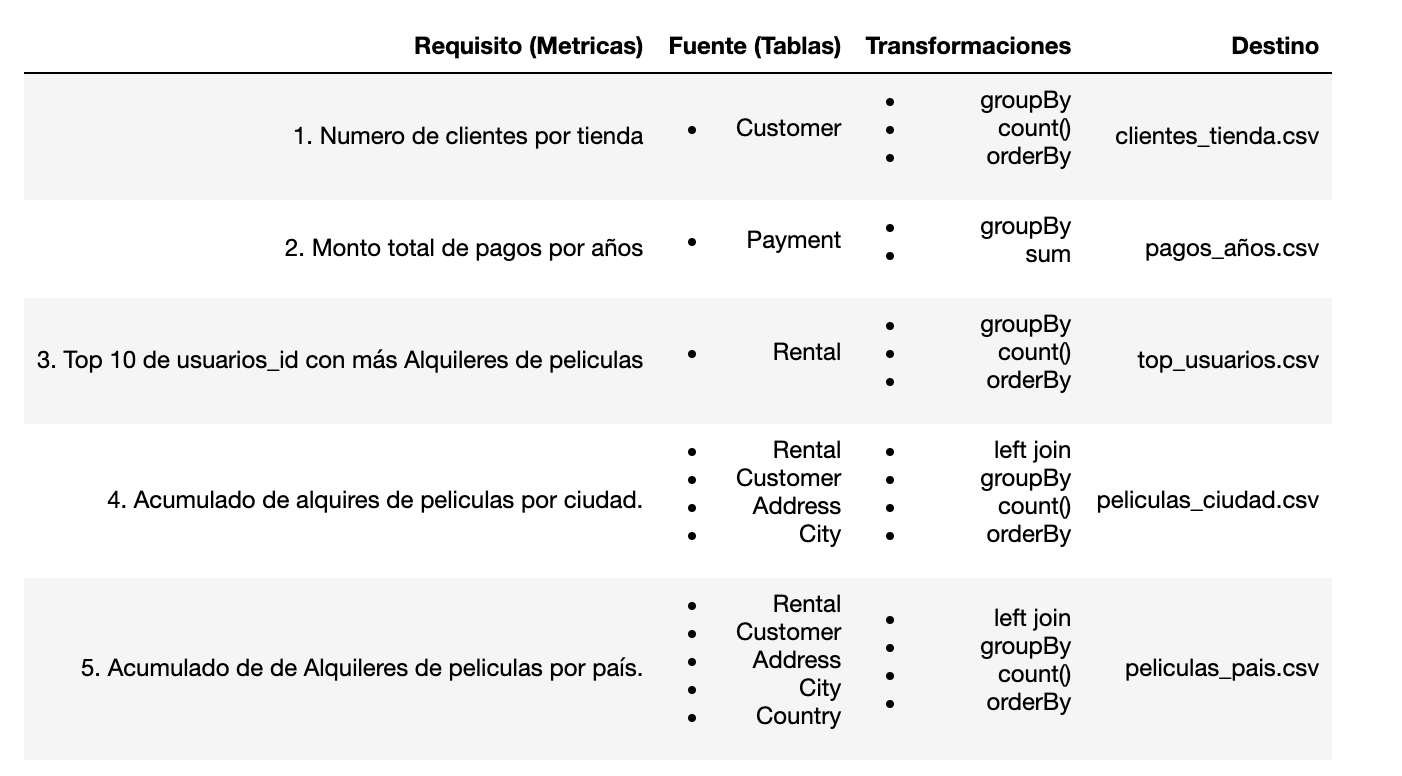

In [14]:
from IPython.display import Image
Image(filename = "requirements_table.png", width = 700, height = 400)

Para realizar la extracción, transformaciones y carga de los datos se usará `PySpark` conectándolo a una fuente MySql y el resultado será exportado en archivos `CSV`.

In [1]:
import os
import findspark
import pyspark.sql.functions as F
from pyspark.sql.functions import year
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import col

In [2]:
from dotenv import load_dotenv
load_dotenv()
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars /Users/jmarrietar/Documents/mysql-connector-java-8.0.21.jar  pyspark-shell'

In [3]:
sc = SparkContext(appName="TestPySparkJDBC")
sqlContext = SQLContext(sc)
spark = SparkSession(sc)

In [4]:
# ENV Variables
HOSTNAME = os.environ['HOSTNAME']
DBNAME = os.environ['DBNAME']
JDBCPORT = 3306
USERNAME = os.environ['USERNAME']
PASSWORD = os.environ['PASSWORD']

In [5]:
jdbc_url = "jdbc:mysql://{0}:{1}/{2}?user={3}&password={4}".format(HOSTNAME, JDBCPORT, DBNAME, USERNAME, PASSWORD)

In [6]:
def get_jdbc_table(table):
    jdbc = (spark
            .read
            .format("jdbc")
            .option("url", "jdbc:mysql://localhost:3306/sakila") 
            .option("driver", "com.mysql.jdbc.Driver") 
            .option("dbtable", table)
            .option("user", USERNAME)
            .option("password", PASSWORD)
            .load())
    return jdbc

In [7]:
# Load external source MySql
jdbcCustomer = get_jdbc_table("customer")
jdbcRental = get_jdbc_table("rental")
jdbcPayment = get_jdbc_table("payment")
jdbcInventory = get_jdbc_table("inventory")
jdbcFilm = get_jdbc_table("film")
jdbcAddress = get_jdbc_table("address")
jdbcCity = get_jdbc_table("city")
jdbcCountry = get_jdbc_table("country")

In [8]:
jdbcCountry.printSchema()

root
 |-- country_id: integer (nullable = true)
 |-- country: string (nullable = true)
 |-- last_update: timestamp (nullable = true)



# Requisitos

### 1. Numero de clientes por tienda

In [9]:
# ETL 
clientes_tienda = (jdbcCustomer
 .select("store_id")
 .groupBy("store_id")
 .count()
 .orderBy("count", ascending=False))

clientes_tienda.show(n=10, truncate=False)

# Save to CSV file
#clientes_tienda.coalesce(1).write.csv('output/clientes_tienda', header = 'true')
clientes_tienda.toPandas().to_csv('output/clientes_tienda.csv')

+--------+-----+
|store_id|count|
+--------+-----+
|1       |326  |
|2       |273  |
+--------+-----+



### 2. Monto total de pagos por años

In [10]:
# ETL 
pagos_años = (jdbcPayment
 .groupBy(year("payment_date"))
 .sum("amount"))

pagos_años.show()

# Save to CSV file
#pagos_años.coalesce(1).write.csv('output/pagos_años', header = 'true')
pagos_años.toPandas().to_csv('output/pagos_años.csv')

+------------------+-----------+
|year(payment_date)|sum(amount)|
+------------------+-----------+
|              2006|     514.18|
|              2005|   66902.33|
+------------------+-----------+



### 3. Top 10 de usuarios_id con mayor alquiler de peliculas

In [11]:
# ETL
top_usuarios = (jdbcRental
 .groupBy("customer_id")
 .count()
 .orderBy("count", ascending=False)
 .limit(10))

top_usuarios.show()

# Save to CSV file
#top_usuarios.coalesce(1).write.csv('output/top_usuarios', header = 'true')
top_usuarios.toPandas().to_csv('output/top_usuarios.csv')

+-----------+-----+
|customer_id|count|
+-----------+-----+
|        148|   46|
|        526|   45|
|        236|   42|
|        144|   42|
|         75|   41|
|        197|   40|
|        469|   40|
|        178|   39|
|        137|   39|
|        468|   39|
+-----------+-----+



### 4. Acumulado de alquires de peliculas por ciudad.

In [12]:
# ETL 
peliculas_ciudad = ((jdbcRental
 .join(
     jdbcCustomer,
     jdbcRental.customer_id == jdbcCustomer.customer_id)
 .join(
     jdbcAddress,
     jdbcCustomer.address_id == jdbcAddress.address_id)
 .join(
     jdbcCity,
     jdbcCity.city_id == jdbcAddress.city_id)
 .select(jdbcRental.rental_id, 
         jdbcRental.customer_id, 
         jdbcCustomer.address_id,
         jdbcAddress.city_id,
         jdbcCity.city)
).groupBy("city")
 .count()
 .orderBy("count", ascending=False))

peliculas_ciudad.show()

# Save to CSV file
#peliculas_ciudad.coalesce(1).write.csv('output/peliculas_ciudad', header = 'true')
peliculas_ciudad.toPandas().to_csv('output/peliculas_ciudad.csv')

+-------------------+-----+
|               city|count|
+-------------------+-----+
|             Aurora|   50|
|             London|   48|
|        Saint-Denis|   46|
|         Cape Coral|   45|
|          Molodetno|   42|
|              Tanza|   42|
|           Changhwa|   41|
|   Ourense (Orense)|   40|
|          Changzhou|   40|
|            Bijapur|   39|
|Santa Brbara dOeste|   39|
|          Apeldoorn|   39|
|            Qomsheh|   38|
|      Richmond Hill|   38|
|             Nantou|   38|
|            Kolpino|   38|
|             Skikda|   37|
|          Balikesir|   37|
|             Ikerre|   37|
|              Beira|   37|
+-------------------+-----+
only showing top 20 rows



### 5. Acumulado de de Alquileres de peliculas por país.

In [13]:
# ETL 
peliculas_pais = ((jdbcRental
 .join(
     jdbcCustomer,
     jdbcRental.customer_id == jdbcCustomer.customer_id)
 .join(
     jdbcAddress,
     jdbcCustomer.address_id == jdbcAddress.address_id)
 .join(
     jdbcCity,
     jdbcCity.city_id == jdbcAddress.city_id)
 .join(
     jdbcCountry,
     jdbcCity.country_id == jdbcCountry.country_id)
 .select(jdbcRental.rental_id, 
         jdbcRental.customer_id, 
         jdbcCustomer.address_id,
         jdbcAddress.city_id,
         jdbcCity.country_id,
         jdbcCountry.country,
         jdbcCity.city)
).groupBy("country")
 .count()
 .orderBy("count", ascending=False))

peliculas_pais.show()

# Save to CSV file
#peliculas_pais.coalesce(1).write.csv('output/peliculas_pais', header = 'true')
peliculas_pais.toPandas().to_csv('output/peliculas_pais.csv')

+------------------+-----+
|           country|count|
+------------------+-----+
|             India| 1572|
|             China| 1426|
|     United States|  968|
|             Japan|  825|
|            Mexico|  796|
|            Brazil|  748|
|Russian Federation|  713|
|       Philippines|  568|
|            Turkey|  388|
|         Indonesia|  367|
|           Nigeria|  352|
|         Argentina|  352|
|            Taiwan|  305|
|      South Africa|  285|
|              Iran|  225|
|    United Kingdom|  219|
|            Poland|  203|
|           Germany|  196|
|             Italy|  189|
|           Vietnam|  172|
+------------------+-----+
only showing top 20 rows



## Resultados

Se usó de manera exitosa `PySpark` para transformar información provenientes de tablas MySQL como fuente, calculando indicadores por medio de transformaciones (ETL) y guardando la información dentro de la carpeta `output` en archivos CSV. 